# Analyse résultats

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import gc
import joblib
import os

from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import (
    cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
)
from sklearn.metrics import (
    precision_score, confusion_matrix, accuracy_score, roc_auc_score, make_scorer, recall_score, f1_score)

In [2]:
from os import listdir
from os.path import isfile, join

In [3]:
path = './res'
res_files = [f for f in listdir(path) if isfile(join(path, f))]

In [4]:
res_files

['clf_rf_100000_50prct.sav.gzip',
 'clf_rf_10000_10prct.sav.gzip',
 'clf_rf_10000_40prct.sav.gzip',
 'clf_svm_10000_40prct.sav.gzip',
 'clf_xgb_100000_50prct.sav.gzip',
 'clf_xgb_10000_10prct.sav.gzip',
 'clf_xgb_10000_40prct.sav.gzip']

In [5]:
results = {}
for f in res_files:
    fpath = os.path.join(path, f)
    with open(fpath, 'rb') as file:
        res = joblib.load(file)#, compress='gzip')
        
    results[f.split('.')[0]] = res
    del res
    

In [6]:
def get_results_as_df(res):
    cols = ['train_score','idx_best_score','time','test_score']

    train_score = [v['best_score_'] for (k,v) in res.items() if k != 'base']
    idx_best_score = [v['idx_best_score'] for (k,v) in res.items() if k != 'base']
    times = [v['time'] for (k,v) in res.items() if k != 'base']
    test_score = [v['test_score'] for(k,v) in res.items() if k != 'base']
    # params = [v['model'].get_params() for v in results.values()]

    data = [train_score, idx_best_score, times, test_score]

    res_df = pd.DataFrame(data, index=cols, columns=list(res.keys())[1:]).T
    
    return res_df

In [14]:
def plot_convergence(results, ylim=None):
    fig, ax = plt.subplots(figsize=(12,7))
    
    for k, opt in results.items():
        if k == 'base':
            continue
        scores = -np.abs(opt['results'])
        
        hist_score = [scores[0]]
        for s in scores[1:]:
            hist_score += [np.min([hist_score[-1], s])]
        
        ax.plot(range(1,len(hist_score)+1), hist_score, label=k)
        ax.scatter(range(1,len(hist_score)+1), hist_score, s=20)
    
    ax.legend()
    ax.set_title('Convergence of different hyperparameter tuning methods')
    ax.set_xlabel('iteration')
    ax.set_ylabel('score')
    
    if ylim is not None: ax.set_ylim(ylim)
    
    ax.grid()
    
    plt.show()

In [11]:
res_df = []
res_dict = {}

for k, res in results.items():
    tmp = get_results_as_df(res)
    tmp = tmp.reset_index()
    tmp['exp'] = k
    res_dict[k] = res
    
    res_df.append(tmp)
    
res_df = pd.concat(res_df)

In [12]:
res_df

,index,train_score,idx_best_score,time,test_score,exp
0,RandomSearch,0.896850,31.0,1514.627317,0.910100,clf_rf_100000_50prct
1,skopt,0.901817,39.0,2083.696280,0.912975,clf_rf_100000_50prct
2,BayesianOptimization,0.902033,52.0,1773.646472,0.910000,clf_rf_100000_50prct
3,optuna,0.900150,31.0,1711.556025,0.910825,clf_rf_100000_50prct
4,hyperopt,0.897383,66.0,1593.055864,0.906725,clf_rf_100000_50prct
0,RandomSearch,0.948266,36.0,190.466790,0.904000,clf_rf_10000_10prct
1,skopt,0.949935,19.0,314.229724,0.908250,clf_rf_10000_10prct
2,BayesianOptimization,0.949099,45.0,319.840899,0.904500,clf_rf_10000_10prct
3,optuna,0.948265,33.0,312.243119,0.903750,clf_rf_10000_10prct
4,hyperopt,0.948099,26.0,241.370649,0.903750,clf_rf_10000_10prct


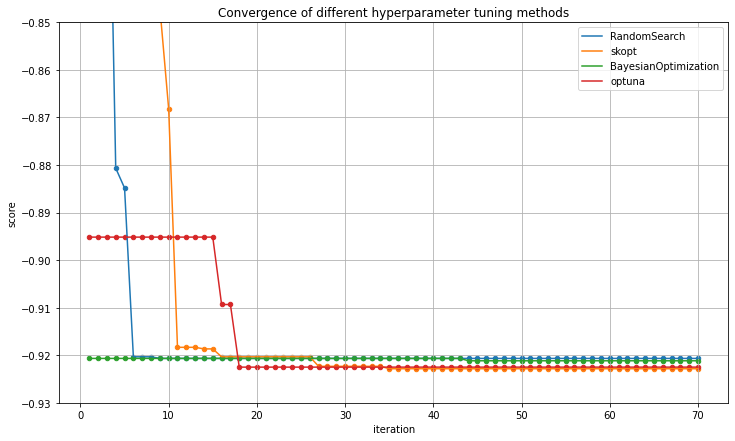

In [17]:
exp = 'clf_svm_10000_40prct'
res = res_dict[exp]
plot_convergence(res, ylim=(-0.93, -0.85))

In [27]:
random_df = res_df.loc[res_df['index'] == 'RandomSearch'].set_index(['exp'])
random_df = random_df.drop(columns='index')
random_df

,train_score,idx_best_score,time,test_score
exp,,,,
clf_rf_10000_10prct,0.948266,36.0,190.466790,0.90400
clf_rf_10000_40prct,0.879833,0.0,164.409045,0.89200
clf_xgb_10000_10prct,0.960424,29.0,112.489041,0.92675
clf_xgb_10000_40prct,0.893500,68.0,80.181544,0.90075


In [28]:
skopt_df = res_df.loc[res_df['index'] == 'skopt'].set_index(['exp'])
skopt_df = skopt_df.drop(columns='index')
skopt_df

,train_score,idx_best_score,time,test_score
exp,,,,
clf_rf_10000_10prct,0.949935,19.0,314.229724,0.90825
clf_rf_10000_40prct,0.883333,37.0,308.675633,0.89450
clf_xgb_10000_10prct,0.960128,32.0,166.261286,0.92925
clf_xgb_10000_40prct,0.899000,49.0,180.730585,0.90625


In [30]:
skopt_df - random_df 

,train_score,idx_best_score,time,test_score
exp,,,,
clf_rf_10000_10prct,0.001669,-17.0,123.762934,0.00425
clf_rf_10000_40prct,0.003500,37.0,144.266587,0.00250
clf_xgb_10000_10prct,-0.000296,3.0,53.772246,0.00250
clf_xgb_10000_40prct,0.005500,-19.0,100.549041,0.00550


In [31]:
skopt_df / random_df 

,train_score,idx_best_score,time,test_score
exp,,,,
clf_rf_10000_10prct,1.001760,0.527778,1.649787,1.004701
clf_rf_10000_40prct,1.003978,inf,1.877486,1.002803
clf_xgb_10000_10prct,0.999691,1.103448,1.478022,1.002698
clf_xgb_10000_40prct,1.006156,0.720588,2.254017,1.006106
